In [58]:
import torch
import torchvision

from torch import nn
from torchsummary import summary   #used for finding summary
from torch.utils.data import DataLoader  
import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.utils import save_image

import time
from progressbar import *
import os
import matplotlib.pyplot as plt 
import numpy as np

In [59]:
#Enable cuda if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, "is available ")

cuda is available 


## Image transformation
* `Normalising images `
* **GPU/CPU** enabled using .to(device) 
* Converting to tensor

In [68]:
#image for transformation 
num_epochs = 100
batch_size = 16
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

### Loading and testing dataloader

* use numpy traspose(1,2,0) to get the data back to orignal dimentions as the dataset output in terms of
`batch, channel, height, widht`

In [69]:
train_dataset = datasets.ImageFolder(root='./dog_data', transform=img_transform)
trainset = DataLoader(dataset = train_dataset,
                     batch_size=batch_size,
                     shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


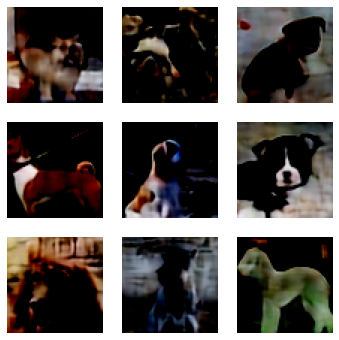

In [100]:
data, _ = next(iter(trainset))
fig = plt.figure(figsize=(12, 6))
for row in range(1, 4):  # show 3 rows
    for col in range(1, 4):  # show 3 columns
        index = 6 * (row - 1) + col
        image = data[index - 1, :] # retrieve images as (28, 28) tensors
        fig.add_subplot(3, 6, index)
        plt.imshow(image.numpy().transpose(1,2,0))

        plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 64, 64])


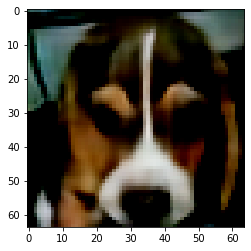

In [96]:
from torch.autograd import Variable
print(data.shape)
output = data[3,:].cpu().detach().numpy().transpose(1,2,0)
plt.imshow(output)
# plt.imshow(data[1,:].reshape(64,64,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


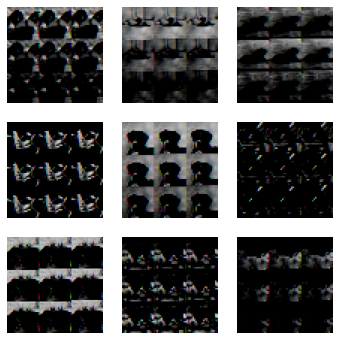

In [72]:

%matplotlib inline
fig = plt.figure(figsize=(12, 6))
for row in range(1, 4):  # show 3 rows
    for col in range(1, 4):  # show 3 columns
        index = 6 * (row - 1) + col
        image = data[index - 1, :]  # retrieve images as (28, 28) tensors
        #print image.shape
        fig.add_subplot(3, 6, index)
        #index = torch.LongTensor([1,2,0])
        #image[index]=image
        plt.imshow(image.reshape(64,64,3))

        plt.axis('off')
plt.show()

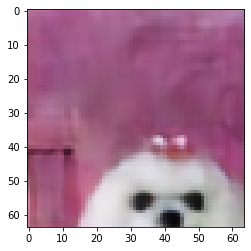

In [73]:
image = plt.imread("./dog_data/dogs/100.png")
plt.imshow(image)
image_tensor = torch.from_numpy(image).reshape([1,64,64,3])

In [75]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 128, 4,stride=1, padding = 2),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1),
                nn.ReLU(),
                nn.ConvTranspose2d(64,3,4, stride=2, padding=1)
        )

    def forward(self, x):
        print(x.size())
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

summary(model, (3,64,64))   #used for finding summary 

torch.Size([2, 3, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 66, 66]             896
              ReLU-2           [-1, 32, 66, 66]               0
         MaxPool2d-3           [-1, 32, 33, 33]               0
            Conv2d-4           [-1, 64, 35, 35]          18,496
              ReLU-5           [-1, 64, 35, 35]               0
         MaxPool2d-6           [-1, 64, 17, 17]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         131,200
              ReLU-8          [-1, 128, 16, 16]               0
   ConvTranspose2d-9           [-1, 64, 32, 32]         131,136
             ReLU-10           [-1, 64, 32, 32]               0
  ConvTranspose2d-11            [-1, 3, 64, 64]           3,075
Total params: 284,803
Trainable params: 284,803
Non-trainable params: 0
----------------------------------------------------------------
Inp

In [76]:
image_tensor2 = torch.from_numpy(image).reshape([1,64,64,3])
image_tensor.size()[1:]

torch.Size([64, 64, 3])

In [77]:
h = image_tensor.reshape(1,3,64,64)
model.forward(h.cuda()).shape

torch.Size([1, 3, 64, 64])


torch.Size([1, 3, 64, 64])

In [78]:
img_transform(image)

tensor([[[ 0.3647,  0.4118,  0.4039,  ...,  0.3804,  0.3569,  0.2706],
         [ 0.3569,  0.3804,  0.3804,  ...,  0.3490,  0.3490,  0.2627],
         [ 0.3020,  0.3490,  0.3490,  ...,  0.3176,  0.2941,  0.3020],
         ...,
         [ 0.4980,  0.3412,  0.2941,  ...,  0.3804,  0.3569,  0.3333],
         [ 0.4902,  0.2784,  0.2392,  ...,  0.3647,  0.3804,  0.3569],
         [ 0.4431,  0.3020,  0.2627,  ...,  0.3961,  0.3961,  0.3882]],

        [[-0.0196, -0.0980, -0.1373,  ...,  0.0196,  0.0275,  0.0196],
         [-0.1137, -0.1686, -0.1765,  ..., -0.0039, -0.0118, -0.0745],
         [-0.1843, -0.2157, -0.2392,  ..., -0.0745, -0.0902, -0.0980],
         ...,
         [-0.0196, -0.2549, -0.2784,  ...,  0.3647,  0.3333,  0.3176],
         [-0.0118, -0.2706, -0.3020,  ...,  0.3569,  0.3569,  0.3333],
         [ 0.0196, -0.2078, -0.2706,  ...,  0.3882,  0.3804,  0.3725]],

        [[ 0.1922,  0.2000,  0.2078,  ...,  0.3490,  0.3647,  0.2706],
         [ 0.1686,  0.1529,  0.1529,  ...,  0

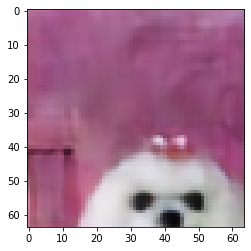

In [79]:
g = image_tensor.reshape(1,3,64,64)
h = image_tensor.numpy().reshape(64,64,3)
plt.imshow(h)
plt.show()

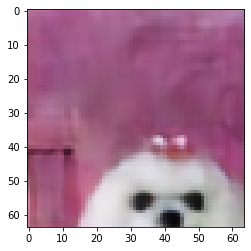

In [80]:
h = image_tensor.numpy().reshape(64,64,3)
plt.imshow(h)
plt.show()

In [81]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def transform_image(data):
    return img_transform(data).reshape(1,3,64,64).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])


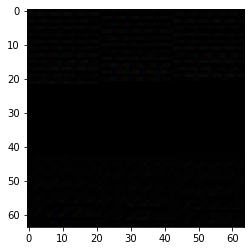

In [82]:
transformed_image = transform_image(image)
output = model.forward(transformed_image)
output = output.cpu().detach().numpy().reshape(64,64,3)
plt.imshow(output)

In [ ]:
output.shape